# WHAT IS THIS NOTEBOOK ABOUT?

# IMPORTS

In [91]:
import requests
import pandas as pd
import maya
from datetime import datetime
import plotly.express as px
import numpy as np

from prophet import Prophet

# EXTERNAL FUNCTIONS

In [138]:
def ManageDateTime(ds_obj):
    return datetime.strftime(maya.parse(ds_obj).datetime(), "%Y-%m-%d %H:%M:%S")

def ManageDateMinute(ds_obj):
    return datetime.strftime(maya.parse(ds_obj).datetime(), "%Y-%m-%d %H:%M:00")
def ManageDateHour(ds_obj):
    return datetime.strftime(maya.parse(ds_obj).datetime(), "%Y-%m-%d %H:00:00")

class InvalidArgument(Exception):
    "Input Either City name or Lat AND Lon for city"
    pass
def GetWeatherData(city = "None", lon = "no", lat= "no", start_date= "yesterday", end_date= "today"):
    if city != "None":
        url = "https://geocoding-api.open-meteo.com/v1/search?name={city_name}&count=10&language=en&format=json".format(city_name = city)
        geo_ = requests.get(url)
        results_ = geo_.json()["results"][0]
        lat = results_["latitude"]
        lon = results_["longitude"]
    elif lat == "no" or lon == "no":
        raise InvalidArgument
    start_date_parsed = datetime.strftime(maya.when(start_date).datetime(), "%Y-%m-%d")
    end_date_parsed = datetime.strftime(maya.when(end_date).datetime(), "%Y-%m-%d")
    url = "https://archive-api.open-meteo.com/v1/archive?latitude={lat}&longitude={lon}&start_date={start_date}&end_date={end_date}&hourly=temperature_2m,cloudcover,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance"\
        .format(lat = lat, lon = lon, start_date = start_date_parsed, end_date = end_date_parsed)
    data = requests.get(url)
    try:
        data = data.json()["hourly"]
    except:
        print(data)
    data = pd.DataFrame(data)
    data["ds"] = data["time"].apply(ManageDateTime)

    url = "https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&past_days=10&hourly=temperature_2m,cloudcover,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance"\
        .format(latitude = lat, longitude = lon)
    forecast_data = requests.get(url)
    forecast_data = pd.DataFrame(forecast_data.json()["hourly"])
    forecast_data["ds"] = forecast_data["time"].apply(ManageDateTime)

    data["type"] = "real"
    forecast_data["type"] = "forecast"


    return pd.concat([data, forecast_data], ignore_index= True)


In [235]:
data = pd.read_feather("/Users/fablab/Renergetic/app/pages_app/data_graph_app.feather")

In [236]:
test_data = data[data.pilot == "Ghent"][data.asset_name == "de-nieuwe-dokken-pv-0198-xxxxx9C0"][data.type == "real"].reset_index()

<ipython-input-236-ffbd0562b5bf>:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [237]:
test_data["ds"] = test_data["ds"].apply(ManageDateMinute)

In [238]:
test_data = test_data[["ds", "value"]].groupby("ds").mean().reset_index(level = "ds")

In [239]:
fig = px.scatter(test_data, x = "ds", y = "value")
fig.update_layout(
        xaxis=dict(
            showline=True,
            showgrid=False,
            showticklabels=True,
            linecolor='rgb(204, 204, 204)',
            linewidth=2,
            ticks='outside',
            tickfont=dict(
                family='Poppins',
                size=12,
                color='rgb(117,161,51)',
            )
        ),
        yaxis = dict(
            showgrid = False,
            linewidth = 2,
            ticks = "outside",
            tickfont = dict(
                family = "Poppins",
                size = 14,
                color = 'rgb(117,161,51)'
            ),
            showticklabels = True
        ),
        showlegend=True,
        title = "PV Time Series",
        plot_bgcolor='rgb(255,255,255)',
        xaxis_title='Datetime',
        yaxis_title='Energy (Wh)',
        height = 350
    )
fig.show()

In [240]:
test_data["ds_hour"] = test_data["ds"].apply(ManageDateHour)

In [251]:
weather_data = GetWeatherData("Ghent", start_date= "1 Mar 2023")

In [252]:
weather_data

time  temperature_2m  cloudcover  shortwave_radiation  \
0     2023-03-01T00:00            -0.8         0.0                  0.0   
1     2023-03-01T01:00            -1.0         0.0                  0.0   
2     2023-03-01T02:00            -1.3         0.0                  0.0   
3     2023-03-01T03:00            -1.5         0.0                  0.0   
4     2023-03-01T04:00            -1.7         0.0                  0.0   
...                ...             ...         ...                  ...   
2395  2023-05-28T19:00            16.7       100.0                109.0   
2396  2023-05-28T20:00            15.9       100.0                 18.0   
2397  2023-05-28T21:00            15.1       100.0                  0.0   
2398  2023-05-28T22:00            14.2       100.0                  0.0   
2399  2023-05-28T23:00            13.4       100.0                  0.0   

      direct_radiation  diffuse_radiation  direct_normal_irradiance  \
0                  0.0                0.0                       0.0   
1                  0.0                0.0                       0.0   
2                  0.0                0.0                       0.0   
3                  0.0                0.0                       0.0   
4                  0.0                0.0                       0.0   
...                ...                ...                       ...   
2395              57.0               52.0                     424.6   
2396               6.0               12.0                     103.8   
2397               0.0                0.0                       0.0   
2398               0.0                0.0                       0.0   
2399               0.0                0.0                       0.0   

                       ds      type  
0     2023-03-01 00:00:00      real  
1     2023-03-01 01:00:00      real  
2     2023-03-01 02:00:00      real  
3     2023-03-01 03:00:00      real  
4     2023-03-01 04:00:00      real  
...                   ...       ...  
2395  2023-05-28 19:00:00  forecast  
2396  2023-05-28 20:00:00  forecast  
2397  2023-05-28 21:00:00  forecast  
2398  2023-05-28 22:00:00  forecast  
2399  2023-05-28 23:00:00  forecast  

[2400 rows x 9 columns]

In [260]:
fig = px.scatter(weather_data, x = "ds", y = "direct_radiation", color = "type")
fig.update_layout(
        xaxis=dict(
            showline=True,
            showgrid=False,
            showticklabels=True,
            linecolor='rgb(204, 204, 204)',
            linewidth=2,
            ticks='outside',
            tickfont=dict(
                family='Poppins',
                size=12,
                color='rgb(117,161,51)',
            )
        ),
        yaxis = dict(
            showgrid = False,
            linewidth = 2,
            ticks = "outside",
            tickfont = dict(
                family = "Poppins",
                size = 14,
                color = 'rgb(117,161,51)'
            ),
            showticklabels = True
        ),
        showlegend=True,
        title = "Direct Radiation Series",
        plot_bgcolor='rgb(255,255,255)',
        xaxis_title='Datetime',
        yaxis_title='Direct Radiation',
        height = 350
    )
fig.show()

In [257]:
pd.isna(weather_data_real.temperature_2m[1991])


True

In [259]:
weather_data_real = weather_data[weather_data.type == "real"]
weather_data_real["check"] = weather_data_real["temperature_2m"].apply(lambda x: pd.isna(x) != True)
weather_data_real = weather_data_real[weather_data_real.check == True]
real_ds = weather_data_real.ds.tolist()

weather_data_forecast = weather_data[weather_data.type == "forecast"]
weather_data_forecast["check"] = weather_data_forecast["ds"].apply(lambda x: x not in real_ds)
weather_data_forecast = weather_data_forecast[weather_data_forecast.check == True]

weather_data = pd.concat([weather_data_real.drop(["check"], axis = 1), weather_data_forecast.drop(["check"], axis = 1)], ignore_index= True)

<ipython-input-259-44a774cc2fdb>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-259-44a774cc2fdb>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [261]:
weather_data = weather_data[["ds", 'temperature_2m', 'cloudcover', 'shortwave_radiation',
       'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance']]
weather_data.columns = ["ds_hour", 'temperature_2m', 'cloudcover', 'shortwave_radiation',
       'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance']

In [262]:
data_merged = pd.merge(test_data, weather_data, on = "ds_hour")

In [263]:
data_merged

ds   value              ds_hour  temperature_2m  \
0      2023-03-01 13:22:00  1711.0  2023-03-01 13:00:00             5.3   
1      2023-03-01 13:26:00  1671.0  2023-03-01 13:00:00             5.3   
2      2023-03-01 13:27:00  1662.0  2023-03-01 13:00:00             5.3   
3      2023-03-01 13:31:00  1634.0  2023-03-01 13:00:00             5.3   
4      2023-03-01 13:32:00  1603.0  2023-03-01 13:00:00             5.3   
...                    ...     ...                  ...             ...   
14029  2023-05-22 19:18:00     0.0  2023-05-22 19:00:00            14.7   
14030  2023-05-22 19:21:00     0.0  2023-05-22 19:00:00            14.7   
14031  2023-05-22 19:29:00     0.0  2023-05-22 19:00:00            14.7   
14032  2023-05-22 19:33:00     0.0  2023-05-22 19:00:00            14.7   
14033  2023-05-22 19:34:00     0.0  2023-05-22 19:00:00            14.7   

       cloudcover  shortwave_radiation  direct_radiation  diffuse_radiation  \
0             0.0                522.0             428.0               94.0   
1             0.0                522.0             428.0               94.0   
2             0.0                522.0             428.0               94.0   
3             0.0                522.0             428.0               94.0   
4             0.0                522.0             428.0               94.0   
...           ...                  ...               ...                ...   
14029        57.0                 79.0              28.0               51.0   
14030        57.0                 79.0              28.0               51.0   
14031        57.0                 79.0              28.0               51.0   
14032        57.0                 79.0              28.0               51.0   
14033        57.0                 79.0              28.0               51.0   

       direct_normal_irradiance  
0                         838.1  
1                         838.1  
2                         838.1  
3                         838.1  
4                         838.1  
...                         ...  
14029                     275.9  
14030                     275.9  
14031                     275.9  
14032                     275.9  
14033                     275.9  

[14034 rows x 9 columns]

In [264]:
px.scatter(data_merged, x = "value", y = "shortwave_radiation")

In [16]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

/Users/fablab/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(data_merged.drop(["ds", "value"], axis = 1), data_merged["value"], test_size = 0.2)

train_pool = Pool(
    X_train, 
    Y_train, 
)
valid_pool = Pool(
    X_test, 
    Y_test,
)

catboost_params = {
    'iterations': 300,
    'learning_rate': 0.5,
    'task_type': 'CPU',
    'early_stopping_rounds': 20,
    'use_best_model': True,
    'verbose': 2
}


model_L2 = CatBoostRegressor(**catboost_params)
model_L2.fit(train_pool, eval_set=valid_pool)
y_pred = model_L2.predict(valid_pool)

0:	learn: 15446.3289532	test: 13813.6023550	best: 13813.6023550 (0)	total: 52.4ms	remaining: 15.7s
2:	learn: 12358.1167876	test: 11145.5022147	best: 11145.5022147 (2)	total: 54.3ms	remaining: 5.37s
4:	learn: 11303.2092507	test: 10253.8218861	best: 10253.8218861 (4)	total: 56.1ms	remaining: 3.31s
6:	learn: 10756.8038009	test: 10138.4652277	best: 10138.4652277 (6)	total: 58ms	remaining: 2.43s
8:	learn: 10413.7955953	test: 10069.8016474	best: 10069.8016474 (8)	total: 60.1ms	remaining: 1.94s
10:	learn: 10013.5084263	test: 9893.3981008	best: 9893.3981008 (10)	total: 61.9ms	remaining: 1.63s
12:	learn: 9441.9982343	test: 10074.1087949	best: 9807.4736714 (11)	total: 63.5ms	remaining: 1.4s
14:	learn: 9016.2399339	test: 10068.9894477	best: 9807.4736714 (11)	total: 65.3ms	remaining: 1.24s
16:	learn: 8699.1186602	test: 9939.3662668	best: 9807.4736714 (11)	total: 67.4ms	remaining: 1.12s
18:	learn: 8391.7483291	test: 9887.1215928	best: 9807.4736714 (11)	total: 69ms	remaining: 1.02s
20:	learn: 7989.2

In [25]:
model_L2.feature_names_

['temperature_2m',
 'cloudcover',
 'shortwave_radiation',
 'direct_radiation',
 'diffuse_radiation',
 'direct_normal_irradiance']

In [24]:
model_L2.feature_importances_

array([11.19917425,  8.53696705, 34.11945502, 21.18713869, 19.32759321,
        5.62967178])

In [18]:
X_test["real"] = Y_test
X_test["pred"] = y_pred

In [19]:
px.scatter(X_test, x = "real", y = "pred")

In [295]:
train_data = data_merged[data_merged.ds < "2023-05-19"]
train_data.columns = ['ds', 'y', 'ds_hour','temperature_2m', 'cloudcover', 'shortwave_radiation',
       'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance']

In [296]:
num_days = 3
measures_per_hour = 60
diff_time = 1

In [297]:
m = Prophet(daily_seasonality=True, weekly_seasonality=True, changepoint_prior_scale = 0.05)
add_regressor_names = ['temperature_2m', 'cloudcover', 'shortwave_radiation',
'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance']


m.add_regressor('shortwave_radiation')
m.add_regressor('temperature_2m')
m.add_regressor("direct_radiation")
m.add_regressor("diffuse_radiation")
m.add_regressor("direct_normal_irradiance")

In [298]:
m.fit(train_data)
from prophet.utilities import regressor_coefficients
add_coef = regressor_coefficients(m)
future = m.make_future_dataframe(periods= 24*(2 + num_days)*measures_per_hour , freq="{minutes}T".format(minutes = diff_time))


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/fablab/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [299]:
add_coef

regressor regressor_mode      center  coef_lower      coef  \
0       shortwave_radiation       additive  247.048387    2.770708  2.770708   
1            temperature_2m       additive   10.374300    0.367727  0.367727   
2          direct_radiation       additive  129.177949    4.239896  4.239896   
3         diffuse_radiation       additive  117.870438    1.276072  1.276072   
4  direct_normal_irradiance       additive  232.160972   -1.293105 -1.293105   

   coef_upper  
0    2.770708  
1    0.367727  
2    4.239896  
3    1.276072  
4   -1.293105

In [300]:
future["ds"] = future["ds"].apply(str)
future["ds_hour"] = future["ds"].apply(ManageDateHour)

In [301]:
future = pd.merge(future, weather_data, on = "ds_hour")

In [302]:
forecast = m.predict(future)

/Users/fablab/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/fablab/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/Users/fablab/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/fablab/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



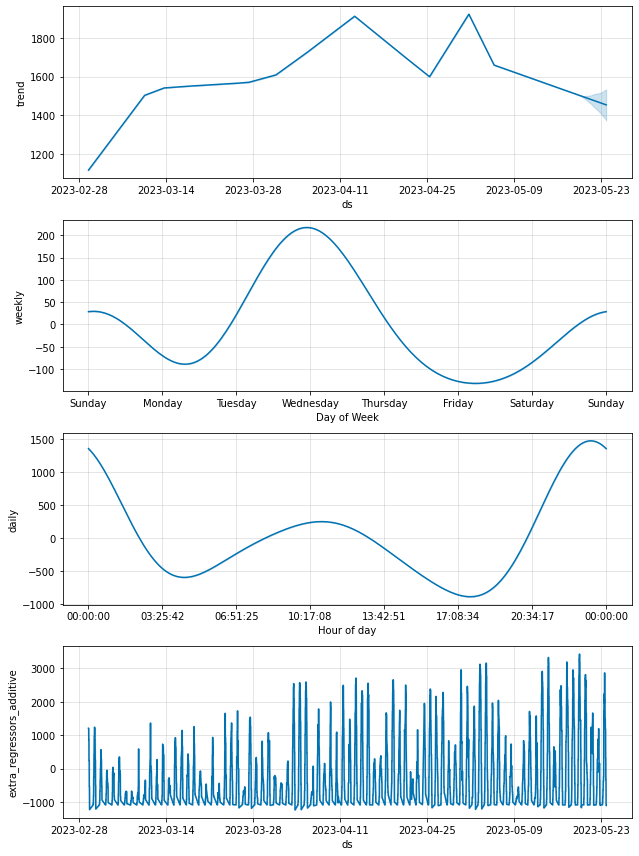

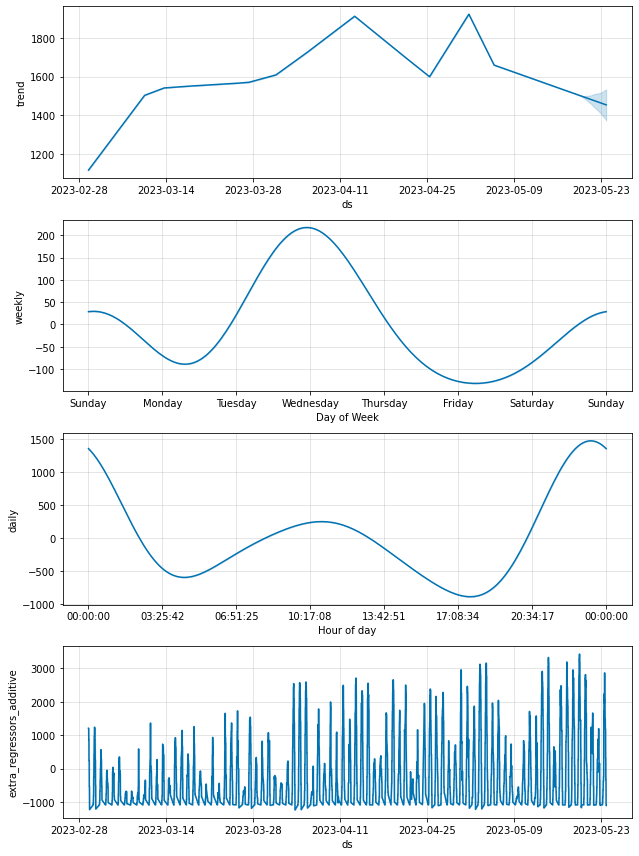

In [303]:
m.plot_components(forecast)

In [304]:
forecast["yhat"] = forecast["yhat"].apply(lambda x: max(x, 0))

In [305]:
forecast["ds"] = forecast["ds"].apply(str)
results = pd.merge(test_data, forecast[["ds", "yhat"]], on = "ds")

In [306]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x = results.ds, y = results.value, name = "real"))
fig.add_trace(go.Scatter(x = results.ds, y = results.yhat, name = "pred_with_weather"))

In [307]:
m = Prophet(daily_seasonality=True, weekly_seasonality=True, changepoint_prior_scale = 0.05)
train_data = train_data[["ds","y"]]
m.fit(train_data)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/fablab/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [308]:
future = m.make_future_dataframe(periods= 24*(2 + num_days)*measures_per_hour , freq="{minutes}T".format(minutes = diff_time))

In [309]:
forecast = m.predict(future)

/Users/fablab/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/fablab/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [310]:
forecast_to_merge = forecast[["ds", "yhat"]]
forecast_to_merge.columns = ["ds", "yhat_noweather"]

In [311]:
forecast_to_merge["ds"] = forecast_to_merge["ds"].apply(str)

<ipython-input-311-8f07141fd559>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [312]:
results = pd.merge(results, forecast_to_merge, on = "ds")

In [313]:
results

ds   value              ds_hour         yhat  \
0      2023-03-01 13:22:00  1711.0  2023-03-01 13:00:00  2377.008084   
1      2023-03-01 13:26:00  1671.0  2023-03-01 13:00:00  2361.424400   
2      2023-03-01 13:27:00  1662.0  2023-03-01 13:00:00  2357.503272   
3      2023-03-01 13:31:00  1634.0  2023-03-01 13:00:00  2341.724555   
4      2023-03-01 13:32:00  1603.0  2023-03-01 13:00:00  2337.757417   
...                    ...     ...                  ...          ...   
14029  2023-05-22 19:18:00     0.0  2023-05-22 19:00:00     0.000000   
14030  2023-05-22 19:21:00     0.0  2023-05-22 19:00:00     0.000000   
14031  2023-05-22 19:29:00     0.0  2023-05-22 19:00:00     0.000000   
14032  2023-05-22 19:33:00     0.0  2023-05-22 19:00:00     0.000000   
14033  2023-05-22 19:34:00     0.0  2023-05-22 19:00:00     0.000000   

       yhat_noweather  
0         1685.690133  
1         1661.137225  
2         1654.858127  
3         1629.191263  
4         1622.639103  
...               ...  
14029      188.121718  
14030      183.739759  
14031      175.903651  
14032      174.086823  
14033      173.851135  

[14034 rows x 5 columns]

In [314]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = results.ds, y = results.value, name = "Real"))
fig.add_trace(go.Scatter(x = results.ds, y = results.yhat, name = "Pred with weather"))
fig.add_trace(go.Scatter(x = results.ds, y = results.yhat_noweather, name = "Pred with no weather"))

In [315]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = results[results.ds > "2023-05-01"].ds, y = results[results.ds > "2023-05-01"].value, name = "Real"))
fig.add_trace(go.Scatter(x = results[results.ds > "2023-05-01"].ds, y = results[results.ds > "2023-05-01"].yhat, name = "Pred with weather"))
fig.add_trace(go.Scatter(x = results[results.ds > "2023-05-01"].ds, y = results[results.ds > "2023-05-01"].yhat_noweather, name = "Pred with no weather"))

In [316]:
test_ = results[results.ds > "2023-05-01"].groupby(["ds_hour"]).sum().reset_index()

In [317]:
test_

ds_hour    value          yhat  yhat_noweather
0    2023-05-01 04:00:00      0.0    801.817137      343.254072
1    2023-05-01 05:00:00   4808.0   3231.933640     5026.107563
2    2023-05-01 06:00:00   9897.0   9993.157312    12547.004144
3    2023-05-01 07:00:00  21869.0  24851.338731    25388.088507
4    2023-05-01 08:00:00  30044.0  34239.907989    30973.186194
..                   ...      ...           ...             ...
356  2023-05-22 15:00:00  12328.0  20358.657154    28463.923590
357  2023-05-22 16:00:00  10215.0   7991.815102    20822.936979
358  2023-05-22 17:00:00   6797.0   8496.200536     9908.538318
359  2023-05-22 18:00:00   1750.0   2860.149515     3344.824306
360  2023-05-22 19:00:00    141.0      0.000000     1944.515738

[361 rows x 4 columns]

In [318]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = test_[test_.ds_hour > "2023-05-15"].ds_hour, y = test_[test_.ds_hour > "2023-05-15"].value, name = "Real"))
fig.add_trace(go.Scatter(x = test_[test_.ds_hour > "2023-05-15"].ds_hour, y = test_[test_.ds_hour > "2023-05-15"].yhat, name = "Pred with weather"))
fig.add_trace(go.Scatter(x = test_[test_.ds_hour > "2023-05-15"].ds_hour, y = test_[test_.ds_hour > "2023-05-15"].yhat_noweather, name = "Pred with no weather"))

In [319]:
mean_squared_error(test_[test_.ds_hour > "2023-05-01"].value, test_[test_.ds_hour > "2023-05-01"].yhat)

82679905.41400936

In [320]:
mean_squared_error(test_[test_.ds_hour > "2023-05-01"].value, test_[test_.ds_hour > "2023-05-01"].yhat_noweather)

182978236.99187422

In [321]:
np.round((mean_squared_error(results.value, results.yhat_noweather)-mean_squared_error(results.value, results.yhat))/(mean_squared_error(results.value, results.yhat_noweather))*100,2)

36.57